# Clustering Geolocation Data Intelligently in Python
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

## Prerequisites
- Basic Matplotlib skills for plotting 2-D data clearly.
- Basic understanding of Pandas and how to use it for data manipulation.
- The concepts behind clustering algorithms, although we will go through this throughout the project.

## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): Clustering Strength / Performance Metric

[**Task 4**](#task4): K-Means Clustering

[**Task 5**](#task5): DBSCAN

[**Task 6**](#task6): HDBSCAN

[**Task 7**](#task7): Addressing Outliers

[**Further Reading**](#further)

In [43]:
!pip install hdbscan

In [0]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

**Note** - 
 
1. cols - list of colours that will help to differentiate between different taxis.

2. DBSCAN - Density-Based Spatial Clustering of Applications with Noise - works as such: Divides the dataset into n dimensions. For each point in the dataset, DBSCAN forms an n dimensional shape around that data point, and then counts how many data points fall within that shape.

3. HDBSCAN - Hierarchical DBSCAN - It extends DBSCAN by converting it into a hierarchical clustering algorithm

4. folium - nice and simple way to draw geographical data. It shows you full world map. It gives you ability to zoom out and go to a particular location.

5. silhouette_score - to give score to cluster algorithm. 

    -1<silhouette_score<1

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [0]:
df = pd.read_csv("/content/Data/taxi_data.csv")

In [46]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

1. lon - longitude 

2. lat - latitude

In [47]:
# find if there is any duplicate value or not
# values will be "FALSE" and "TRUE"
# any() will give True if there anu true value
df.duplicated(subset=['LON','LAT']).values.any()

True

In [48]:
# find if there us any missing values
df.isna().values.any()
# OR df.isnull().values

True

In [49]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

df.dropna(inplace=True)  # to remove missing values
# keep - which to keep of all duplicates
df.drop_duplicates(subset=['LON','LAT'], keep = 'first', inplace=True)  # removing duplicate values

print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [50]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [51]:
X = np.array(df[['LON','LAT']], dtype='float64')
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

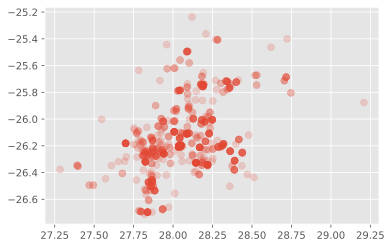

In [52]:
# scatter plot
plt.scatter(X[:,0],X[:,-1], alpha = 0.2, s=50)
# alpha - It makes everything a little bit lighter. So dense clusters can be viewed properly.
# s - size of circle

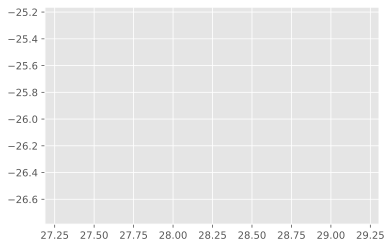

In [53]:
plt.scatter(X[:,0],X[:,-1], alpha = 0, s=50)

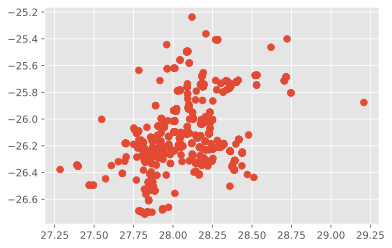

In [54]:
plt.scatter(X[:,0],X[:,-1], alpha = 1, s=50)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [55]:
# Map - It will give us full world map 
# location - Give particular location that you wanna show at map
# tiles - Several tiles are available: OpenStreetMap, Stamen Terrain, Stamen Toner, Mapbox Bright, and Mapbox Control Room. 
#         Note that the tile you need probably depends on the zoom you want to apply to your map.
# zoom_start (int, default 10) – Initial zoom level for the map.
m = folium.Map(location = [df.LAT.mean(), df.LON.mean()], zoom_start = 9,
               tiles = 'Stamen Toner')

m

In [56]:
j = folium.Map(location = [df.LAT.mean(), df.LON.mean()], zoom_start = 2,
               tiles = 'Stamen Toner')

j

In [57]:
j = folium.Map(location = [df.LAT.mean(), df.LON.mean()], zoom_start = 20,
               tiles = 'Stamen Toner')

j

In [58]:
print(re.sub(r'[^a-zA-Z ]+', '', "11th Street Taxi Rank"))
print(re.sub(r'[^a-zA-Z ]+', '', "Wadeville Ext 1 Taxi Rank")) # ^ means. instead of a-zA-Z replace others with '' i.e empty i.e remove them

th Street Taxi Rank
Wadeville Ext  Taxi Rank


In [0]:
for _, row in df.iterrows(): # it will return a tuple
  folium.CircleMarker(
      location = [row.LAT, row.LON],
      radius = 10, # size
      popup = re.sub(r'[^a-zA-Z ]+', '', row.NAME),  # when you will click on circle what will popup
      color = '#1787FE',  # giving colour to circle 
      fill=True,   # will fill colour inside circle . In this map alpha makes the colour red lighter if we zoom in on a single circle but overlapped red is visible
      fill_color = 'red'
  ).add_to(m)    # add all these functionalities on our map

In [60]:
m

<a id='task3'></a>
# Task 3: Clustering Strength / Performance Metric

**clustering** is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters).

In [0]:
# center=10 means 10 clusters
# n_features - X,Y feature
# cluster_std - giving standard deviation to each cluster
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2,
                        cluster_std=0.5, random_state=4)

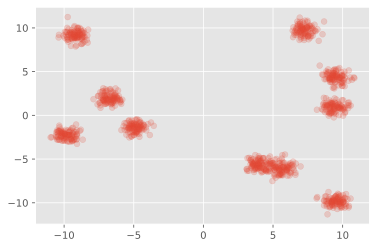

In [62]:
plt.scatter(X_blobs[:,0], X_blobs[:,-1], alpha=0.2)

In [63]:
class_predictions = np.load('/content/Data/sample_clusters.npy') #.npy is numpy array file
# upr humne jo clusters liye hain unhe humne cluster number diya hai .npy file ke rup mein. .npy file ek algo nhi hai simple ek 
# numpy array file hoti hai jo python create krti hai. iska matlab issmein sirf ek rray hota hai in other words this file loads a single array.
class_predictions #printing the array loaded from numpy file

array([2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0,
       2, 0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
       2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1,
       1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0,

In [64]:
unique_clusters = np.unique(class_predictions) #total no. of clusters are displayed with their lables
print("unique clusters:",unique_clusters)
print("\nclass prediction:",class_predictions) # jo hm=umne array load kiya hai
print("\nX_blobs:",X_blobs) # jo humne sample data bnaya ghai
# sample data aur array dono 1000 hi hain
print("len of class predictions",class_predictions.shape)

unique clusters: [0 1 2]

class prediction: [2 2 2 2 1 0 1 0 2 1 2 1 2 0 2 1 1 1 1 1 2 0 2 0 2 1 2 0 0 1 2 1 0 2 0 2 2
 1 1 0 0 2 2 2 2 1 2 1 0 2 1 2 1 1 1 2 2 2 2 2 0 0 2 2 1 0 2 2 0 1 2 2 0 2
 2 2 0 0 1 2 1 2 0 2 2 1 2 2 1 2 2 0 2 1 2 2 1 0 2 2 2 0 1 0 1 2 0 0 2 2 0
 2 0 1 2 1 1 1 1 2 1 1 0 2 0 1 1 2 1 2 0 0 2 0 1 1 0 2 0 0 0 0 2 1 0 2 2 2
 2 0 0 2 0 2 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 2 2 0 2 0 2 2 0 1 2 1 1 2 0 1
 1 2 1 2 0 2 1 0 2 2 2 0 2 1 2 2 2 1 2 2 1 2 2 2 0 1 2 2 1 1 2 2 0 2 0 2 1
 0 2 0 2 1 0 0 0 2 2 2 1 2 1 0 0 1 0 2 1 1 2 0 2 0 2 2 1 0 0 0 1 1 2 1 1 0
 0 1 0 2 2 1 0 2 1 0 0 2 1 2 1 0 0 2 2 2 0 1 0 1 0 2 1 0 1 1 0 1 0 1 2 2 2
 0 0 1 2 0 0 1 0 2 2 2 2 2 1 2 1 0 0 1 1 1 2 1 2 2 1 1 2 0 1 2 1 2 2 2 0 1
 2 1 1 1 2 1 2 2 0 1 0 0 2 1 2 2 1 0 0 0 2 1 1 0 2 0 0 0 0 1 0 0 2 0 2 0 2
 1 1 0 2 0 1 0 2 1 2 0 1 0 2 1 1 0 0 2 2 1 1 0 0 2 0 2 0 1 0 2 2 0 0 2 0 1
 0 2 2 1 2 0 2 2 0 0 0 1 2 0 1 1 2 1 2 0 2 2 0 0 1 1 0 2 2 1 1 0 1 2 2 2 2
 1 1 2 2 0 1 0 2 0 2 0 2 1 2 0 2 0 0 0 1 1 2 2 2 0 1 1 2

In [65]:
print(class_predictions==0)

[False False False False False  True False  True False False False False
 False  True False False False False False False False  True False  True
 False False False  True  True False False False  True False  True False
 False False False  True  True False False False False False False False
  True False False False False False False False False False False False
  True  True False False False  True False False  True False False False
  True False False False  True  True False False False False  True False
 False False False False False False False  True False False False False
 False  True False False False  True False  True False False  True  True
 False False  True False  True False False False False False False False
 False False  True False  True False False False False False  True  True
 False  True False False  True False  True  True  True  True False False
  True False False False False  True  True False  True False False  True
  True  True  True  True False False  True False  T

Now how this true false arrays is returned. This is the difference between array and numpy array. If you instantiate an array and compare it with a sungle number.

- a = [0,1,2,3,4]
- b=0
- print(a==b) it wont be able to compare and return false because datatype is not same. Had the data type been same it would have returned tre or false depending on the values


ON THE OTHER HAND.
Numpy array will compare the value of each and return a true false array as above.
This true false array if passed to another numpy array it will return a numpy array with values corresponding to true.
which is done in below code



In [66]:
arr=np.array([10,20,30,40,50,60])
a=np.array([0,2,0,0,1,0])
b=0
c=arr[a==b]
print(c)

[10 30 40 60]


In [67]:
arr=[10,20,30,40,50]
a=[0,2,0,0,1]
b=0
print(a==b)


False


In [68]:
arr=np.array([10,20,30,40,50,60])
a=np.array([0,2,0,0,1,0])
b=0
c=arr[a==b]
print(c)

[10 30 40 60]




 [[ 7.83653481  9.45255692]
 [ 8.06230342  9.62618109]
 [ 9.4920478   1.36983842]
 [ 9.81794608  1.20626881]
 [ 9.05698115  4.12133161]
 [ 6.54300942  9.20517622]
 [ 8.92894373  4.26154671]
 [ 9.95520348  1.74458374]
 [10.43804689  5.13277309]
 [ 9.95052909  3.75500678]
 [ 9.35868628  5.16904213]
 [ 6.44193293  8.93670018]
 [ 9.09915744  0.45193575]
 [ 9.3645999  -0.23439183]
 [ 7.47592438 10.8203611 ]
 [ 9.8102306   4.32250517]
 [ 8.55414206  9.27773891]
 [ 6.78273838 10.44599975]
 [ 9.76827325  4.67389064]
 [ 8.58857585  4.61902774]
 [ 9.57062399  4.14608722]
 [ 7.38289373  9.47627778]
 [ 9.08157235  4.12569188]
 [ 8.96581182  4.94257844]
 [ 9.3564002   4.00602229]
 [ 9.32541826  4.3790001 ]
 [ 9.86104996  0.74031983]
 [ 9.05815913  0.17318046]
 [ 7.00371049  9.24442157]
 [10.05094533  4.04695951]
 [ 9.39693614  3.26061153]
 [ 9.89588111  4.93750356]
 [ 9.35991439  0.70422041]
 [ 6.80458369  9.35568579]
 [ 6.46434519 10.07817324]
 [ 7.13118174  9.8772598 ]
 [ 9.90286171  4.28650176

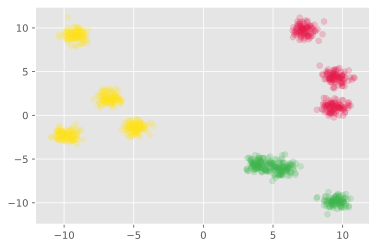

In [69]:
for unique_cluster in unique_clusters:
  X = X_blobs[class_predictions==unique_cluster] #the true false array generated by class_predictions==unique_cluster is given to X_blobs and true values are stored in
  # X array. This means X frst contains the 0 cluster array and prints them then 1 then 2.    
  print("\n\n",X)
  plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])#colour will be given according to unique cluster number cols[0] or cols[1] or cols[2]
  

In [70]:
silhouette_score(X_blobs, class_predictions) # gives value from -1 tp +1. Better score better cluster

0.6657220862867241

cluster predictions: [1 6 7 7 4 3 2 3 5 4 6 2 5 0 1 9 2 2 9 9 6 0 7 8 1 9 5 3 8 2 1 2 0 7 8 5 7
 2 9 8 8 5 7 5 6 2 7 9 3 6 4 7 4 2 9 6 5 1 6 7 0 0 6 7 4 3 7 6 8 4 5 5 3 7
 6 1 3 8 9 5 9 7 8 1 1 4 5 7 4 7 7 8 1 2 5 7 2 3 6 6 7 8 4 8 2 6 8 8 7 1 0
 5 0 2 7 2 2 9 2 6 2 4 3 5 8 2 2 6 4 7 8 8 7 0 4 4 3 6 3 3 8 8 1 9 0 6 6 7
 7 3 3 1 0 5 2 3 0 8 0 0 2 2 0 2 3 2 2 2 2 2 6 1 3 7 8 1 6 8 4 1 4 2 6 3 2
 4 5 2 6 0 6 9 3 6 1 5 3 5 4 5 7 6 4 5 5 4 5 5 7 0 2 1 7 9 2 6 6 0 1 0 1 4
 0 7 8 7 4 0 8 0 6 7 7 2 5 4 8 0 4 3 1 4 4 7 8 5 3 6 1 4 8 0 0 4 9 1 4 2 8
 0 9 3 6 5 4 0 6 2 3 0 1 2 5 9 8 0 7 1 7 0 9 0 4 0 7 9 3 4 9 8 2 0 9 5 5 6
 3 3 2 1 3 3 4 3 5 5 1 6 1 9 7 9 3 8 4 9 4 5 2 1 6 2 4 7 3 2 7 2 1 6 5 8 9
 6 9 9 9 1 2 7 5 8 9 0 0 6 2 7 1 9 3 8 8 6 4 2 0 6 0 3 0 0 4 0 3 7 8 6 3 5
 9 4 3 1 8 9 3 1 2 1 8 2 0 6 2 4 8 8 7 6 9 9 0 8 1 3 1 3 2 8 1 7 3 3 7 0 9
 0 6 5 9 1 3 6 6 8 8 0 9 5 3 2 4 7 9 5 8 5 5 3 0 4 4 0 1 1 2 9 0 4 5 5 7 7
 9 4 6 1 3 9 8 1 3 1 3 6 9 5 0 1 8 8 8 9 9 5 6 1 0 4 9 7 2 4 1 7 0 2 2 1 4
 7 4

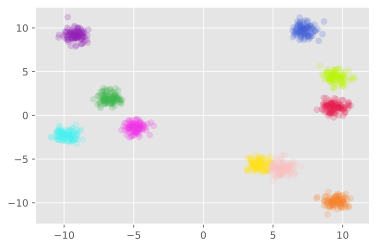

In [71]:
class_predictions_imporoved = np.load('/content/Data/sample_clusters_improved.npy')
print("cluster predictions:",class_predictions_imporoved)
unique_clusters_imporoved = np.unique(class_predictions_imporoved)
for unique_cluster_imporoved in unique_clusters_imporoved:
  X = X_blobs[class_predictions_imporoved==unique_cluster_imporoved]    # same as above
  plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster_imporoved])

In [72]:
silhouette_score(X_blobs, class_predictions_imporoved)

0.7473587799908298

**Note** - 

1. sample_clusters_improved is better than sample_clusters because sample_clusters_improved's silhouette_score is more closer to 1.

<a id='task4'></a>
# Task 4: K-Means Clustering

In [0]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4) #create random data for viewing purpose only

In [74]:
dic1 = defaultdict(dict) #helps in dictionary within dictionary
dic1[0]["a"]="A" #basically dictionary at index 0
dic1[1]["b"]="B"
dic1[2]["c"]="C"
print(dic1) #printing overall view
print(dic1[0]) #printing first index
print(dic1[0]["a"]) #printing final value of key value pair of first index

defaultdict(<class 'dict'>, {0: {'a': 'A'}, 1: {'b': 'B'}, 2: {'c': 'C'}})
{'a': 'A'}
A


In [75]:
data = defaultdict(dict) #created dictionary from defaultdict model
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    #create dictionary within a dictionary
    data[x]['class_predictions'] = model.predict(X_blobs) #get the value of cluster labels
    data[x]['centroids'] = model.cluster_centers_ #get the value of centroids
    data[x]['unique_classes'] = np.unique(data[x]['class_predictions']) # total clusters in our predictions
print(data[1]) #starting of range is 1 so there is no data[0]

{'class_predictions': array([2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1,
       2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 0, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 0,
       0, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2,
       2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 0,
       1, 1, 1, 2, 2, 2, 0, 1, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 1, 1, 0,
       0, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1, 0, 2, 1, 2,
       1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2, 1, 0, 2, 2, 0, 2,
       1, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 0, 0, 0, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 1, 0,
       1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 0, 2, 2, 1, 0, 0, 0, 0, 2, 1, 0, 2,
       0, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 2,
       0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 0, 1, 2, 0, 2, 2, 1, 0, 0, 1, 1, 1, 2, 1, 2, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 1

In [76]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], #first coloumn i.e LAT
                        X_blobs[class_predictions==unique_class][:,1], # second column i.e LON
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15]) #x and y axis go from -15 to +15
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))# create interavtive user interface with f function passing x value from 1-20 (decided from slider) because we ran out loop from 1-20 while populating data in X
output = interactive_plot.children[-1] #https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#interactive we take only output from interactive widget to set the height to 350px in next step
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [0]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [78]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15
2  27.83239 -26.53722          Adams Road Taxi Rank                 5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18

In [79]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

     
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]
            
        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= str(row[cluster_column]), #it
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6367300948961482


In [80]:
m

In [81]:
best_silhouette, best_k = -1, 0

# the range starts from 2 as 1 cluster makes no point
for k in tqdm(range(2, 100)): #tqdm is keras progress bar library to show the progress 
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
print("\n")     
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



K=98
Silhouette Score: 0.6971995093340411


<a id='task5'></a>
# Task 5: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [82]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])
print(dummy)
new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])
print(new)

[-1 -1 -1  2  3  4  5 -1]
[-2 -3 -4  2  3  4  5 -9]


In [0]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_ #predict wont work here like in the KMeans

df['CLUSTERS_DBSCAN'] = class_predictions # add column to df

In [84]:
m = create_map(df, 'CLUSTERS_DBSCAN') #create a map . it will give -1 for outliers i.e nodes with less than 5 near them.

    
print(f'Number of clusters found: {len(np.unique(class_predictions))}') # f means format i.e when we need to add a variable value
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}') # how many clusters have -1 value



print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)]) #converting outliers in single individual clusters
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')
print(f'Silhouette taking outliers as one: {silhouette_score(X, class_predictions)}')#here all outliers are -1 i.e one cluster name -1

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.5667489350583482
Silhouette taking outliers as one: 0.2992028900672389


In [85]:
m

<a id='task6'></a>
# Task 6: HDBSCAN
Hierarchical DBSCAN

In [0]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)
#min_cluster_size is minimum size to be potentially considered a cluster less than this it will not be considered as cluster but outlier/noise or part of another cluster. Ideally this is a relatively intuitive parameter to select – set it to the smallest size grouping that you wish to consider a cluster.
#min_samples The simplest intuition for what min_samples does is provide a measure of how conservative you want your clustering to be. The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas
#cluster_slection_epsilon is the radius around a node to check

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [87]:
m = create_map(df, 'CLUSTER_HDBSCAN')#HDBSCAN outliers ko kum kredega har baar khatam nhi kr pata. Outliers are still known as -1 in cluster labels. Inko last mein deal krenge

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.638992483305273


<a id='task7'></a>
# Task 7: Addressing Outliers


In [0]:
classifier = KNeighborsClassifier(n_neighbors=1)#KNN with odd k so that we can compare neighbours and assign cluster

In [0]:
df_train = df[df.CLUSTER_HDBSCAN!=-1] #identified clusters as training set
df_predict = df[df.CLUSTER_HDBSCAN==-1] #outliers as prediction set

In [0]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64') #the ones whoose cluster labels need to be predicted

In [91]:
classifier.fit(X_train, y_train) #fit the model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
predictions = classifier.predict(X_predict) #predict values

In [0]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN'] #create a new copy of hdbscan cluster labels to convert it to new one with outliers fitted properly

In [0]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions #in the new column created replace -1 with predicted values of new cluster labels

In [0]:
m = create_map(df, 'CLUSTER_hybrid')

In [96]:
m

In [97]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}') #the silhoutte score is low but better clustering because of density based approach.
# k means will have high score but will create very very large clusters and our problem need the service stations to be within reach so HDBSCAN with outliers handled is better approach

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 0, 'Cluster Sizes')

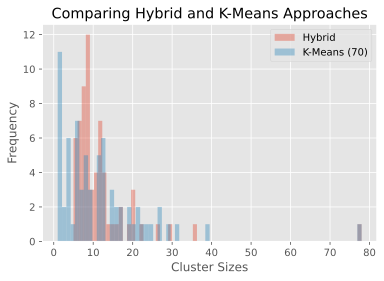

In [98]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, 
                                              label='Hybrid') #Plotting cluster sizes of huybrid approach and kmeans approach
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')

<a id='further'></a>
# Further Reading

For some additional reading, feel free to check out [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) clustering respectively.

It may be of use to also check out [other forms of clustering](https://scikit-learn.org/stable/modules/clustering.html) that are commonly used and available in the scikit-learn library. HDBSCAN documentation also includes [a good methodology](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) for choosing your clustering algorithm based on your dataset and other limiting factors.